In [0]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


# IMPORTS

In [1]:
import datetime
import os
import random
import statistics as stats
import numpy as np
import scipy.signal as scsig
from scipy.io import loadmat
from scipy.signal import medfilt
import pywt
from pywt import wavedec
#from ecgdetectors import Detectors
#import hrv
import matplotlib
import matplotlib.pyplot as plt
#from PIL import Image
import matplotlib.ticker as ticker

import tensorflow as tf
from tensorflow.keras.layers import Dense, Input, LSTM
from tensorflow.keras.models import Model, Sequential
from keras.utils import to_categorical


Using TensorFlow backend.


# GLOBAL DECLEARATIONS

In [7]:
#===========================================================================================================
# 1 DEFINE DIRECTORIES
#===========================================================================================================
global_dir = '/content/drive/My Drive/Masters/workdir/ecg_data'
# global annotation and mapping, common for all ECG from https://physionet.org/about/database/
global_annot = os.path.join(global_dir, 'annotations.txt' ) 
global_matdir = os.path.join(global_dir, 'db_mat')

global_npydir = os.path.join(global_dir, 'db_npy')
os.makedirs(global_npydir , exist_ok = True) 

global_modeldir = os.path.join(global_dir, 'db_model') 
os.makedirs(global_modeldir , exist_ok = True) 

global_datadir = os.path.join(global_dir, 'db_dataset') 
os.makedirs(global_modeldir , exist_ok = True) 

print('GLOBAL DIR :: '+global_dir)
print('GLOBAL MAT DIR :: '+global_matdir)
print('GLOBAL NPY DIR :: '+global_npydir)
print('GLOBAL MODEL DIR :: '+global_modeldir)
print('GLOBAL DATA DIR :: '+global_datadir)
print('GLOBAL ANNOTATIONS :: '+global_annot)

#===========================================================================================================
# 2 Define annotation mapping dictionary (from global_annot)
# view this file on drive :: https://drive.google.com/open?id=1edhzatX7D3Uo03-d08Lksp807ULlcpgo
#=========================================================================================================== 
g_map_data = np.loadtxt(global_annot, dtype='str',delimiter="\t")
g_map={}
print('ANNOTATION MAPPING :: ')
for a in g_map_data:
    g_map[a[0]]= int(a[1])
    print(str(a[0])+'\t'+str(a[1])+'\t'+str(a[2]))
    #a[0] = orignal mit label (char)
    #a[1] = mapped integer label (int)
    #a[2] = description (str)
print('')
g_map_keys = g_map.keys()
print('Annotations : [' + str(len(g_map_keys))+'] :: ' + str(g_map_keys))
def mapstd(peak_label):
    res = np.zeros(len(peak_label),dtype='int')
    for i in range(0, len(peak_label)):
        res[i] = g_map[peak_label[i]]
    return res

#===================================================================================================================
g_LABELS = ['N','B','A']
g_COUNT = len(g_LABELS)
g_COLORS = ['green','blue','red']
print(datetime.datetime.now())
#===================================================================================================================
#===================================================================================================================
#===================================================================================================================
#===================================================================================================================

#---------------------------------------------------------------------------------------------------------------------------------------------
# CLASS ecg_record : represents one ECG Record in any database
#---------------------------------------------------------------------------------------------------------------------------------------------
class ecg_record:

    def __init__(self, db, recname):
        self.db = db                                # class:{ecg_db}    object this record belongs to
        self.rec = recname                          # string            name of this record
        self.name = db.name + '_'+ recname          # string            full name including db.name

        if recname in db.recs_exc:
            print('WARNING:: Record "'+ recname +'" was excluded from database '+ db.name )
        else:
            if not(recname in db.recs):
                print('WARNING:: Record "'+ recname +'" not found in database '+ db.name )

        #self.dirs = db.get_dirs(recname)            # dict              dict of npy data file names to be loaded in data dict used in self.load_data('key')
        self.data = {}                              # dict              dict of npy data file content used in self.read_data('key')

        # find the gain
        self.info = get_minfo(os.path.join(db.dir_mat,recname+'m.hea'))#,db.lead2_index+1)  # head has this info at lead2's index
        self.gain = int(self.info[db.lead2_index+1].split()[2].split('/')[0])
        self.gain5 = int(self.info[db.lead5_index+1].split()[2].split('/')[0])
        #print(self.info)
    
    def print_info(self):
        res = ''
        for i in range(0,len(self.info)):
            res+= self.info[i]
        return res

    def read_data(self, data_type):
        if data_type in self.data.keys():
            return self.data[data_type] #= np.load(self.dirs[s])
        else:
            return self.load_data(data_type)

    def save_data(self, data_type, data_array):
        ipath = os.path.join(self.db.dir_npy, self.rec + '_'+data_type+'.npy')
        np.save(ipath, data_array)
        return ipath

    def load_data(self, data_type):
        ipath = os.path.join(self.db.dir_npy, self.rec + '_'+data_type+'.npy')
        try: # try to load this data
            self.data[data_type] = np.load(ipath) # adds this to dictionary so next time it can read
        except:
            print('WARNING:: Cant load "'+data_type+ '" file at '+ str(ipath) )
            raise Exception("File not found")
        finally:
            return self.data[data_type] #= np.load(self.dirs[s])
#---------------------------------------------------------------------------------------------------------------------------------------------


#---------------------------------------------------------------------------------------------------------------------------------------------
# CLASS ecg_db : represents one ECG database
#---------------------------------------------------------------------------------------------------------------------------------------------
class ecg_db:
    def __init__(self, dbname,  sampling_rate, lead2_index, lead5_index, exclude_rec):
        print('\nInitailze new ecg database ... ')
        self.name = dbname  #str
        self.srate = sampling_rate #int
        self.lead2_index = lead2_index #int
        self.lead5_index = lead5_index #int
        #self.dir_raw = global_dir + dbname+'_raw/' #str
        self.dir_mat = os.path.join(global_matdir , dbname+'_mat') #str
        self.dir_npy = os.path.join(global_npydir , dbname+'_npy') #str
        self.recs_all = set(np.loadtxt(os.path.join(self.dir_mat,'RECORDS'), dtype='str',delimiter="\n")) #set
        self.recs_exc = set(exclude_rec)
        self.recs = set.difference(self.recs_all, self.recs_exc) 
        self.recs_dict = {}
        #for r in self.recs:
        #    self.recs_dict[r] = None #self.get_record(r)
        self.info()

    def info(self):
        print( 'DB NAME :: '+ self.name)
        print( 'MAT DIR :: ' + self.dir_mat )
        print( 'NPY DIR :: ' + self.dir_npy )
        print( 'S_RATE :: ' + str(self.srate))
        print( 'LEAD2 INDEX  :: ' + str(self.lead2_index))
        print( 'LEAD5 INDEX  :: ' + str(self.lead5_index))
        print( 'RECORD SET :: [' +str(len(self.recs))+'] ' + str(self.recs) )
        return 0

    def get_record(self,rec):
        if not (rec in self.recs_dict.keys()):
            self.recs_dict[rec] = ecg_record(self,rec)
        return self.recs_dict[rec]

#---------------------------------------------------------------------------------------------------------------------------------------------


#---------------------------------------------------------------------------------------------------------------------------------------------
# Pre processing Functions
#---------------------------------------------------------------------------------------------------------------------------------------------

def denoise_signal(X, dwt_transform, dlevels, cutoff_low, cutoff_high):
    coeffs = wavedec(X, dwt_transform, level=dlevels)   # wavelet transform 'bior4.4'
    # scale 0 to cutoff_low 
    for ca in range(0,cutoff_low):
        coeffs[ca]=np.multiply(coeffs[ca],[0.0])
    # scale cutoff_high to end
    for ca in range(cutoff_high, len(coeffs)):
        coeffs[ca]=np.multiply(coeffs[ca],[0.0])
    Y = pywt.waverec(coeffs, dwt_transform) # inverse wavelet transform
    return Y  

def get_median_filter_width(sampling_rate, duration):
    res = int( sampling_rate*duration )
    if res % 2 == 0 : # is even
        res+=1 # make odd
    return res

def filter_signal(X,mfltrs_array):
    X0 = X  #read orignal signal
    for mi in range(0,len(mfltrs_array)):
        X0 = medfilt(X0,mfltrs_array[mi]) # apply median filter one by one on top of each other
    X0 = np.subtract(X,X0)  # finally subtract from orignal signal
    return X0

def get_minfo(minfo_path):
    f = open(minfo_path,'r')
    ls = f.readlines()
    f.close()
    #la = ls[minfo_line_index].split()    #I67m.mat 16+192 623/mV 16 0 4441 1894 0 II
    return ls # gain at 2 baseline at 4

#---------------------------------------------------------------------------------------------------------------------------------------------

#------------------------- signal data types--------------------

g_NBEAT_POSTFIX = 'nbeat'
g_BEAT_POSTFIX = 'beat'
g_MBEAT_POSTFIX = 'mbeat'
g_RAW2_POSTFIX = 'raw2'
g_RAW5_POSTFIX = 'raw5'

g_MED2_POSTFIX = 'med2'
g_MED5_POSTFIX = 'med5'

g_DEN2_POSTFIX = 'den2'
g_DEN5_POSTFIX = 'den5'

g_FLT2_POSTFIX = 'flt2'
g_FLT5_POSTFIX = 'flt5'
#------------------------- signal data types--------------------

#heart -rate params
H_min = 30 #bpm
H_low = 60 #bpm
H_hig = 100 #bpm
H_max = 200 #bpm
min_rri = 60/H_min #sec
max_rri = 60/H_max #sec
low_rri = 60/H_low #sec
hig_rri = 60/H_hig #sec

BASIC_SAMPLING_RATE = 128 #Hz

def get_signal(binfo, db_dict, do_normalize, round_up, resamp, g_postfix):  # all_db
    #print(binfo)
    b_db = str(binfo[0])
    b_rec = str(binfo[1])
    b_ppeak = int(binfo[2])
    b_cpeak = int(binfo[3])
    b_npeak = int(binfo[4])
    
    e_rec = db_dict[b_db].get_record(b_rec) # is an 'ecg_record' object
    sr_ratio = BASIC_SAMPLING_RATE/e_rec.db.srate
    signal = e_rec.read_data(g_postfix)[b_ppeak:b_npeak]    # Lead II
    len_ind = len(signal)
    len_sec = round(len_ind/e_rec.db.srate, round_up)
    peak_location = b_cpeak - b_ppeak # 0 based peak location
    if resamp:
        signal = scsig.resample(signal, round(len_ind*sr_ratio))
        len_ind = len(signal)
        len_sec = round(len_ind/BASIC_SAMPLING_RATE, round_up)
        peak_location = round(peak_location*sr_ratio)
    if do_normalize:
        #med5 = np.multiply(med5,[1/e_rec.gain])
        signal = np.multiply(signal,[1/e_rec.gain])
    return signal, peak_location, len_sec

def view_beat(binf, ffigure, dotpi, db_dict, g_postfix, lcol):
    #print ('call view_beat() '+ str(binf))
    sigval, peak, len_time = get_signal(  binf , db_dict, True, 3, True, g_postfix )
    #print("Time Dur = " +str(len_time))
    plt.figure(ffigure, figsize=(len_time*4,6), dpi=dotpi)
    plt.ylim(-2.5,2.5)
    plt.xlim(0-1,len(sigval)+1)

    tick_x = np.arange(0,len(sigval),0.2*BASIC_SAMPLING_RATE)
    tick_y =  np.round( tick_x * 1/BASIC_SAMPLING_RATE,2) 
    plt.xticks(tick_x,tick_y)

    plt.ylabel('Voltage(mV)')
    plt.xlabel('Time(sec)')

    plt.vlines(peak, -2.5,2.5,linestyles='dotted',linewidth=0.4)
    plt.plot(sigval, label=g_postfix, linewidth=0.4, color=lcol)
    plt.title(str(binf)+'::'+ str(len_time)+ 'sec' )
    plt.legend()
    return



#------------------------- beat-info array structure --------------------
def save_binfo_array(recobj):
        f_beats = rec.read_data(g_BEAT_POSTFIX)             # Load beats file
        rlabels = f_beats[:,1]
        rpeaks = f_beats[:,0]

        prev_peaks = rpeaks[0:-2].astype('int')
        current_peaks = rpeaks[1:-1].astype('int')
        next_peaks = rpeaks[2:].astype('int')

        # always next - prev
        prev_rri = (current_peaks-prev_peaks) / rec.db.srate
        next_rri = (next_peaks-current_peaks) / rec.db.srate
        succ_rri_peaks = next_rri - prev_rri

        b_fin = np.transpose(np.vstack((
             np.full(len(rpeaks)-2,b_db,dtype='U10' ),      # 0 db
             np.full(len(rpeaks)-2,b_rec,dtype='U10'),      # 1 rec
             rpeaks[0:-2],                                  # 2 prev peak
             rpeaks[1:-1],                                  # 3 current peak
             rpeaks[2:],                                    # 4 next peak
             rlabels[0:-2],                                 # 5 prev label 
             rlabels[1:-1],                                 # 6 current label
             rlabels[2:],                                   # 7 next label
             succ_rri_peaks.astype('U10'),                  # 8 succ rri diff in seconds
             prev_rri.astype('U10'),                        # 9 prev rri in seconds
             next_rri.astype('U10')                         # 10 next rri in seconds
             )))
        return b_fin
#------------------------- beat-info array structure --------------------
def get_binfo_data(beats_info):
    bi_db = beats_info[:,0]
    bi_rec = beats_info[:,1]

    #peaks
    bi_pp = beats_info[:,2].astype('int')
    bi_pc = beats_info[:,3].astype('int')
    bi_pn = beats_info[:,4].astype('int')

    #labels
    bi_lp = mapstd(beats_info[:,5])
    bi_lc = mapstd(beats_info[:,6])
    bi_ln = mapstd(beats_info[:,7])

    # succesive rri difference in seconds
    bi_srri = beats_info[:,8].astype('float')
    bi_prri = beats_info[:,9].astype('float')
    bi_nrri = beats_info[:,10].astype('float')

    return bi_db, bi_rec, bi_pp, bi_pc, bi_pn, bi_lp, bi_lc, bi_ln, bi_srri, bi_prri, bi_nrri
#------------------------- beat-info array structure --------------------




#======================= NEURAL NETWORK PERFORMANCE MEASURES
#=========================================================================================================================
# 3.3 :: define performance evaluation functions

def get_performance(conf_matrix):
    #how many classes? = len of conf_matril
    nos_class = len(conf_matrix[0,:]) # len of 0th row
    res = np.zeros((0,8),dtype ='float64')
    for i in range(0,nos_class):
        # for each class calculate 4 performance measure - ACC, PRE, SEN, SPF, 
        # first compute TP, TN, FP, FN
        TP = conf_matrix[i,i]
        FP = np.sum(conf_matrix[:,i]) - TP
        FN = np.sum(conf_matrix[i,:]) - TP
        TN = np.sum(conf_matrix) - FN - FP - TP

        ACC = (TP+TN)   /   (TP+FP+FN+TN)
        PRE = (TP)      /   (TP+FP)
        SEN = (TP)      /   (TP+FN)
        SPF = (TN)      /   (TN+FP)

        res_i = np.array([TP, FN, FP, TN, ACC, PRE, SEN, SPF])
        res = np.vstack((res,res_i))
    return res

#------------------------------------------------------------------PRINTING

def print_lstr(class_labels):
    g_LSTR=''   # HEADER ROW for printing confusing matrix
    for i in range(0,len(class_labels)):
        g_LSTR+='\t'+str(class_labels[i])
    return  g_LSTR

def print_cf_row(cf_row,nos_labels):
    res = ''
    for j in range(0,nos_labels):
        res += '\t'+ str(cf_row[j])
    return res
def print_conf_matrix(conf_matrix, suffix, class_labels):
    res=(suffix+'A\\P' + print_lstr(class_labels)+'\n')
    nos_l=len(class_labels)
    for i in range(0,nos_l):
        res+=(suffix+str(class_labels[i]) + print_cf_row(conf_matrix[i],nos_l )+'\n')
    return res
def print_performance(perf_measures, class_labels):
    nos_class = len(perf_measures[:,0])
    print('Performance for '+str(nos_class)+' classes')
    print ('Class\tACC\tPRE\tSEN\tSPF')
    for i in range(0, nos_class):
        perf_i = np.round(perf_measures [i,:],2)
        #print('\tT.P : '+str(perf_i[0])+'\tF.N : '+str(perf_i[1]))
        #print('\tF.P : '+str(perf_i[2])+'\tT.N : '+str(perf_i[3]))
        print(str(class_labels[i])+'\t'+str(perf_i[4])+'\t'+str(perf_i[5])+'\t'+str(perf_i[6])+'\t'+str(perf_i[7]))
    return
#------------------------------------------------------------------PRINTING

GLOBAL DIR :: /content/drive/My Drive/Masters/workdir/ecg_data
GLOBAL MAT DIR :: /content/drive/My Drive/Masters/workdir/ecg_data/db_mat
GLOBAL NPY DIR :: /content/drive/My Drive/Masters/workdir/ecg_data/db_npy
GLOBAL MODEL DIR :: /content/drive/My Drive/Masters/workdir/ecg_data/db_model
GLOBAL DATA DIR :: /content/drive/My Drive/Masters/workdir/ecg_data/db_dataset
GLOBAL ANNOTATIONS :: /content/drive/My Drive/Masters/workdir/ecg_data/annotations.txt
ANNOTATION MAPPING :: 
N	0	Normal beat
L	0	Left bundle branch block beat
R	0	Right bundle branch block beat
B	-1	Bundle branch block beat (unspecified)
A	1	Atrial premature beat
a	1	Aberrated atrial premature beat
J	1	Nodal (junctional) premature beat
S	1	Supraventricular premature or ectopic beat (atrial or nodal)
V	1	Premature ventricular contraction
r	1	R-on-T premature ventricular contraction
F	1	Fusion of ventricular and normal beat
e	1	Atrial escape beat
j	1	Nodal (junctional) escape beat
n	1	Supraventricular escape beat (atrial or n

# DB DICT CREATION

In [8]:

all_db = {}
mitdb_ex = [
            '102', '104', '107', '217',     # contains paced beats
            '212', '231',                   # contains both Normal and BBB type beats
            '207'                           # contains both RBBB and LBBB type beats
            ]
all_db['mitdb'] = ecg_db('mitdb', 360, 0, 1, mitdb_ex)

svdb_ex = [
           '852'                            # missing lead2 signal
          ]
all_db['svdb'] = ecg_db('svdb',  128, 0, 1,svdb_ex)

incartdb_ex = []
all_db['incartdb'] = ecg_db('incartdb', 257, 1, 10,incartdb_ex)
#print(all_db.values())
print('')
print(all_db.keys())


Initailze new ecg database ... 
DB NAME :: mitdb
MAT DIR :: /content/drive/My Drive/Masters/workdir/ecg_data/db_mat/mitdb_mat
NPY DIR :: /content/drive/My Drive/Masters/workdir/ecg_data/db_npy/mitdb_npy
S_RATE :: 360
LEAD2 INDEX  :: 0
LEAD5 INDEX  :: 1
RECORD SET :: [41] {'105', '106', '124', '116', '114', '121', '123', '112', '103', '230', '117', '203', '210', '205', '213', '234', '108', '109', '232', '223', '200', '215', '214', '100', '228', '222', '115', '209', '208', '221', '202', '111', '122', '113', '119', '219', '220', '201', '118', '233', '101'}

Initailze new ecg database ... 
DB NAME :: svdb
MAT DIR :: /content/drive/My Drive/Masters/workdir/ecg_data/db_mat/svdb_mat
NPY DIR :: /content/drive/My Drive/Masters/workdir/ecg_data/db_npy/svdb_npy
S_RATE :: 128
LEAD2 INDEX  :: 0
LEAD5 INDEX  :: 1
RECORD SET :: [77] {'855', '843', '894', '801', '861', '862', '875', '892', '893', '826', '864', '866', '863', '867', '873', '809', '850', '858', '876', '859', '824', '805', '821', '853', 

# [ * ONE TIME * ] DB Building

In [0]:
#    C A R E F U L   D O N T     R U N    T H I S 
#---------------------------------------------
approach = 1  # select Filtering approach
db_data = all_db.values()
#---------------------------------------------------------------------------------------------------------------------------------------------
# Database Building Functions
#---------------------------------------------------------------------------------------------------------------------------------------------

#---------------------------------------------------------------------------------------------------------------------------------------------
# 1 Build Annotations :: a.txt -> ant.npy
def build_db_ants(self_db, output_postfix_beat,output_postfix_nonbeat, gmaps):  
#---------------------------------------------------------------------------------------------------------------------------------------------
    #global g_map_keys
    #global g_map
    gmaps_keys = gmaps.keys()
    xs=len(self_db.recs)
    #xc=1
    print('\nBEGIN TASK :: Build annotations for ' + str(xs)+ ' records')
    print('REC\tFound\tBEAT\tNONB' )
    for rec in self_db.recs:
        #print('REC: '+rec+ '...'+str(xc)+ ' of '+ str(xs))
        #xc+=1
        ants = np.loadtxt(os.path.join(self_db.dir_mat , rec + 'a.txt'), dtype='str', delimiter= '\n', skiprows = 1)
        #print('\tFound Annotations\t'+str(len(ants)))
        antsbeat = np.zeros((0,2),dtype='str')
        antsnonbeat = np.zeros((0,2),dtype='str')
        #print('  annotations found '+str(len(ants)))
        for i in range(0,len(ants)):
            a_a = ants[i].split()
            a_sample = a_a[1]
            a_label = a_a[2]
            
            if a_label in gmaps_keys:
                bmaped = gmaps[a_label]
                if bmaped > -2:
                    antsbeat = np.vstack((antsbeat,np.array([a_sample,a_label]))) # sample,label str
                else: # is non beat
                    antsnonbeat = np.vstack((antsnonbeat,np.array([a_sample,a_label]))) # sample,label str
            else:
                print('\tWARNING :: Unknown annotation "'+a_label+'" found at [' +a_sample+ '] in file a.txt, skipping....')
        
        #adf =  len(ants) - len(antsnpy) 
        #print('\tKnown Annotations\t'+str(len(antsnpy)))
        # print('\tUnknown Annotations\t'+str(adf))
        print(rec + '\t'+ str(len(ants)) + '\t'+str(len(antsbeat))+'\t' + str(len(antsnonbeat) ))
        # save for this record
        np.save(os.path.join(self_db.dir_npy , rec+ '_'+output_postfix_beat+'.npy'), antsbeat)
        np.save(os.path.join(self_db.dir_npy , rec+ '_'+output_postfix_nonbeat+'.npy'), antsnonbeat)
        #print('\tSaved at "'+save_loc+'"')
    print('\nEND TASK :: Build annotations for ' + str(xs)+ ' records')
    return 0
#---------------------------------------------------------------------------------------------------------------------------------------------


#---------------------------------------------------------------------------------------------------------------------------------------------
# 2 Extract Raw lead2 signal :: m.mat[lead2] -> raw2.npy
def build_db_signal(self_db, output_postfix, lead_indices):  # saves xm.mat[lead2] --> x_raw2.npy
#---------------------------------------------------------------------------------------------------------------------------------------------
    xs=len(self_db.recs)
    xc=0
    print('\nBEGIN TASK :: Save signal data for ' + str(xs)+ ' records')
    for rec in self_db.recs:
        xc+=1
        print('Rec: '+rec+ ' ... '+ str(xc)+' of '+ str(xs))
        mat_signal = loadmat(os.path.join( self_db.dir_mat , rec + 'm.mat'))['val']#[self_db.lead2_index]
        for li in range(0,len(lead_indices)):
            np.save(os.path.join( self_db.dir_npy , rec + '_'+output_postfix[li]+'.npy'), mat_signal[lead_indices[li]])    
    print('END TASK :: Save signal data for ' + str(xs)+ ' records')
    return 0
#---------------------------------------------------------------------------------------------------------------------------------------------

#---------------------------------------------------------------------------------------------------------------------------------------------
# 3a Filter Raw/Denoised signal :: raw2.npy -> med2.npy or den2.npy -> rmd2.npy
def filter_db_signal(self_db, ms_flt_array, input_postfix, output_postfix): 
#---------------------------------------------------------------------------------------------------------------------------------------------
    xs=len(self_db.recs)
    xc=0
    mfa = np.zeros(len(ms_flt_array), dtype='int')
    #print('fun')
    for i in range(0, len(ms_flt_array)):
        mfa[i] = get_median_filter_width(self_db.srate,ms_flt_array[i])
        #print('loop')
    print('\nBEGIN TASK :: filer signal data for ' + str(xs)+ ' records:' + input_postfix + ' --> ' + output_postfix)
    for rec in self_db.recs:
        xc+=1
        print('Rec: '+rec+ ' ... '+ str(xc)+' of '+ str(xs))
        X = np.load(os.path.join( self_db.dir_npy , rec + '_'+input_postfix+'.npy')) #np.save(rec_fnpy + '_raw2.npy', mat_signal) 
        X_med2 = filter_signal(X, mfa)
        np.save(os.path.join( self_db.dir_npy , rec + '_'+output_postfix+'.npy'),X_med2) # save a copy of (median filtered ) signal = r,m  
        #----------------------------------------------------------------------         
    print('END TASK :: filer signal data for ' + str(xs)+ ' records')
    return 0
#---------------------------------------------------------------------------------------------------------------------------------------------


#---------------------------------------------------------------------------------------------------------------------------------------------
# 3b Denoise Raw/Filtered signal :: med2.npy -> rdm2.npy or raw2.npy -> den2.npy
def denoise_db_signal(self_db, dwt_transform, dlevels, cutoff_low, cutoff_high, input_postfix, output_postfix):
#---------------------------------------------------------------------------------------------------------------------------------------------
    xs=len(self_db.recs)
    xc=0
    
    print('\nBEGIN TASK :: denoising signal data for ' + str(xs)+ ' records:' + input_postfix + ' --> ' + output_postfix)
    for rec in self_db.recs:
        xc+=1
        print('Rec: '+rec+ ' ... '+ str(xc)+' of '+ str(xs))
        X = np.load(os.path.join( self_db.dir_npy , rec + '_'+input_postfix+'.npy') ) # np.load(self_db.dir_npy + rec + '_raw2.npy')
        X_rlt2 = denoise_signal(X,dwt_transform, dlevels, cutoff_low, cutoff_high )
        np.save(os.path.join( self_db.dir_npy , rec + '_'+output_postfix+'.npy'),X_rlt2) # save a copy of (only denoised)  signal = r,m,d 
        #----------------------------------------------------------------------         
    print('END TASK :: denoising signal data for ' + str(xs)+ ' records')
    return 0
#---------------------------------------------------------------------------------------------------------------------------------------------
#---------------------------------------------------------------------------------------------------------------------------------------------

print(datetime.datetime.now())
print('S T A R T \n')

for db in db_data:
#=========================================================================================
    print ('\n START ON DATABASE: '+ db.name +' \t'+ str(datetime.datetime.now()))
    directory = os.makedirs(os.path.join(global_npydir, db.name+'_npy') , exist_ok = True) 
#=========================================================================================

#=========================================================================================
# STEP 0 : (REQUIRED : Annotation data)
#=========================================================================================
    print ('\n COPY ANNOTATIONS \t'+ str(datetime.datetime.now()))
    # def build_db_ants(self_db, output_postfix):
    build_db_ants(db, g_BEAT_POSTFIX,g_NBEAT_POSTFIX, g_map)  


#=========================================================================================
# STEP 1 : (REQUIRED : Signal Data)
#=========================================================================================
    print ('\n EXTRACT RAW SIGNAL \t'+ str(datetime.datetime.now()))
    # def build_db_signal(self_db, output_postfix, lead_indices):  # saves xm.mat[lead2] --> x_raw2.npy
    # use build_db_signal(db, [g_RAW?_POSTFIX],[db.lead?_index]) 
    build_db_signal(db, [g_RAW2_POSTFIX],[db.lead2_index])
    build_db_signal(db, [g_RAW5_POSTFIX],[db.lead5_index]) 

#=========================================================================================
# STEP 3 : (Preprocessing)
#=========================================================================================
    print ('\n FILTER :: RAW -> MED \t'+ str(datetime.datetime.now()))
    # def filter_db_signal(self_db, ms_flt_array, input_postfix, output_postfix): 
    filter_db_signal(db, [0.2,0.6], g_RAW2_POSTFIX, g_MED2_POSTFIX) 
    filter_db_signal(db, [0.2,0.6], g_RAW5_POSTFIX, g_MED5_POSTFIX) 

    if approach==0:
        # STEP 3.a : First 'median Filter' the signal then 'denoise' it
        #=========================================================================================
        print ('\n DENOISE :: MED -> FLT \t'+ str(datetime.datetime.now()))
        # def denoise_db_signal(self_db, dwt_transform, dlevels, cutoff_low, cutoff_high, input_postfix, output_postfix):
        denoise_db_signal(db, 'bior4.4', 11 , 2 , 9, g_MED2_POSTFIX, g_FLT2_POSTFIX )
        denoise_db_signal(db, 'bior4.4', 11 , 2 , 9, g_MED5_POSTFIX, g_FLT5_POSTFIX )
        
    else:
        # STEP 3.b : First 'denoise' the signal then 'median filter' it
        #=========================================================================================
        print ('\n DENOISE :: RAW -> DEN \t'+ str(datetime.datetime.now()))
        # def denoise_db_signal(self_db, dwt_transform, dlevels, cutoff_low, cutoff_high, input_postfix, output_postfix):
        denoise_db_signal(db, 'bior4.4', 11 , 2 , 9, g_RAW2_POSTFIX, g_DEN2_POSTFIX )
        denoise_db_signal(db, 'bior4.4', 11 , 2 , 9, g_RAW5_POSTFIX, g_DEN5_POSTFIX )
        print ('\n FILTER :: DEN -> FLT \t'+ str(datetime.datetime.now()))
        # def filter_db_signal(self_db, ms_flt_array, input_postfix, output_postfix):  
        filter_db_signal(db, [0.2,0.6], g_DEN2_POSTFIX, g_FLT2_POSTFIX) 
        filter_db_signal(db, [0.2,0.6], g_DEN5_POSTFIX, g_FLT5_POSTFIX) 
        
    
#=========================================================================================
    print ('\n END ON DATABASE:'+ db.name +' \t'+ str(datetime.datetime.now()))
#=========================================================================================
print('\n E N D ')
print(datetime.datetime.now())
#    C A R E F U L   D O N T     R U N    T H I S 




2020-03-11 05:38:10.363280
S T A R T 


 START ON DATABASE: mitdb 	2020-03-11 05:38:10.364474

 COPY ANNOTATIONS 	2020-03-11 05:38:10.365783

BEGIN TASK :: Build annotations for 41 records
REC	Found	BEAT	NONB
210	2685	2650	35
124	1634	1619	15
208	3040	2955	85
215	3400	3363	37
103	2091	2084	7
230	2466	2256	210
115	1962	1953	9
209	3052	3005	47
234	2764	2753	11
117	1539	1535	4
101	1874	1865	9
105	2691	2572	119
220	2069	2048	21
222	2634	2483	151
232	1816	1780	36
219	2312	2154	158
213	3294	3251	43
118	2301	2278	23
108	1824	1763	61
113	1796	1795	1
223	2643	2605	38
100	2274	2273	1
203	3108	2980	128
202	2146	2136	10
111	2133	2124	9
116	2421	2412	9
123	1519	1518	1
214	2297	2262	35
228	2141	2053	88
201	2039	1963	76
205	2672	2656	16
119	2094	1987	107
122	2479	2476	3
200	2792	2601	191
106	2098	2027	71
121	1876	1863	13
114	1890	1879	11
233	3152	3079	73
112	2550	2539	11
221	2462	2427	35
109	2535	2532	3

END TASK :: Build annotations for 41 records

 EXTRACT RAW SIGNAL 	2020-03-11 05:38:12.262200

BE

# [ * ONE TIME * ] MAP BINFO

In [0]:
db_data = all_db.values()
c2 = 0
print(g_MBEAT_POSTFIX+'_REC\t#beats')
for db in db_data:
    b_db = db.name                                          # get records of db
    for b_rec in db.recs:
        rec = db.get_record(b_rec)                          # get rec obj
        #print (rec.name)
        c = save_binfo_array(rec)
        c2 += len(c)
        rec.save_data( g_MBEAT_POSTFIX, c )
        print(rec.name+'\t'+str(len(c)))
print(g_MBEAT_POSTFIX + ' found\t' + str(c2))

mbeat_REC	#beats
mitdb_215	3361
mitdb_119	1985
mitdb_105	2570
mitdb_112	2537
mitdb_220	2046
mitdb_108	1761
mitdb_230	2254
mitdb_201	1961
mitdb_116	2410
mitdb_103	2082
mitdb_123	1516
mitdb_106	2025
mitdb_100	2271
mitdb_219	2152
mitdb_209	3003
mitdb_200	2599
mitdb_222	2481
mitdb_115	1951
mitdb_117	1533
mitdb_101	1863
mitdb_205	2654
mitdb_203	2978
mitdb_232	1778
mitdb_234	2751
mitdb_113	1793
mitdb_118	2276
mitdb_114	1877
mitdb_214	2260
mitdb_109	2530
mitdb_111	2122
mitdb_124	1617
mitdb_221	2425
mitdb_202	2134
mitdb_213	3249
mitdb_228	2051
mitdb_233	3077
mitdb_210	2648
mitdb_121	1861
mitdb_122	2474
mitdb_223	2603
mitdb_208	2953
svdb_870	2676
svdb_847	1760
svdb_859	3540
svdb_872	1979
svdb_879	2060
svdb_880	3485
svdb_850	1836
svdb_821	3131
svdb_808	1772
svdb_845	2885
svdb_864	1893
svdb_827	1860
svdb_800	1881
svdb_843	2706
svdb_844	1707
svdb_861	2470
svdb_802	1669
svdb_810	1901
svdb_883	1818
svdb_809	2542
svdb_826	2659
svdb_811	1434
svdb_894	2345
svdb_848	4257
svdb_829	1965
svdb_862	2186
svdb

#  [1] DATASET GENERATION CRITERIA

In [0]:
#[ beats_info=selrec.load_data('ant_m') ]
def sel_beat_test1(beats_info, do_shuffle, rec_prefix):
    beats_taken = []
    
    bi_db, bi_rec, bi_pp, bi_pc, bi_pn, bi_lp, bi_lc, bi_ln, bi_srri, bi_prri, bi_nrri = get_binfo_data(beats_info)
    bi_srri = np.absolute(bi_srri)
    #-----------------------------------------------------------------------------------------------
    # selecting abnormal beats
    beats_2_take_A = 50
    beats_2_have_A =int(beats_2_take_A*1.2)

    # Select Abnormal Beats
    beats_info_A = beats_info[(bi_lc==1)] #<------ THIS IS A
    nos_A = len(beats_info_A)
    sel_A = set([])
    if nos_A >= beats_2_have_A:
        while len(sel_A)<beats_2_take_A:
            sel_A.add(random.randint( 0, nos_A-1 ))
    #else:
        #print(selrec.name + '\t___\t___\t___' ) 
        #print('   ...Not enough A beats to choose from ... skipped' )

    #-----------------------------------------------------------------------------------------------
    # selecting normal beats
    beats_2_take_N = 30
    beats_2_have_N = int(beats_2_take_N*1.2)
    succ_rri_for_N = 0.1 # if differnece in succesvie rri are more than this then its not normal
    
    # select Normal beats
    beats_info_N = beats_info[(bi_lc==0) & (bi_lp==0) & (bi_ln==0) & (bi_srri <= succ_rri_for_N)] #<----- THIS IS N
    nos_N = len(beats_info_N)
    sel_N = set([])

    if nos_N >= beats_2_have_N:
        while len(sel_N)<beats_2_take_N:
            sel_N.add(random.randint( 0, nos_N-1 ))
    #else:
        #print(selrec.name + '\t___\t___\t___' ) 
        #print('   ...Not enough N beats to choose from ... skipped' )

    #-----------------------------------------------------------------------------------------------
    # selecting Both type beats
    beats_2_take_B = 20
    beats_2_have_B = int(beats_2_take_B*1)
    #succ_rri_for_B = 0.1 # if differnece in succesvie rri are more than this then its not normal
    
    # select Normal beats
    beats_info_B = beats_info[ (bi_lp==0) & ((bi_ln!=0) | (bi_lc!=0)) ] #<----- THIS IS B
    nos_B = len(beats_info_B)
    sel_B = set([])

    if nos_B >= beats_2_have_B:
        while len(sel_B)<beats_2_take_B:
            sel_B.add(random.randint( 0, nos_B-1 ))
    #else:
        #print(selrec.name + '\t___\t___\t___' ) 
        #print('   ...Not enough B beats to choose from ... skipped' )

    bs_N = beats_info_N[list(sel_N)]
    bs_A = beats_info_A[list(sel_A)]
    bs_B = beats_info_B[list(sel_B)]
    nos_A = len(bs_A)
    nos_B = len(bs_B)
    nos_N = len(bs_N)
    nos_total = nos_N+nos_A+nos_B
    # Selected both N and A beats not stack it
    beats_taken.extend( bs_N )
    beats_taken.extend( bs_A )
    beats_taken.extend( bs_B )
    
    #print(beats_taken)
    for i in range(0,do_shuffle):
        random.shuffle(beats_taken)
    print(rec_prefix+ '\t'+ str(nos_total)+ '\t'+str(nos_N)+'\t'+str(nos_B)+'\t'+str(nos_A) )
    return beats_taken
    #-------------------------------------------------------------------------------------------




# [2] DATASETS GENERATION

2.1. Select dabase and records

In [10]:

gds_dict = {} 
gds_dict['mitdb'] = []#list(all_db['mitdb'].recs)      #['208','114', '108']
gds_dict['svdb'] = []#list(all_db['svdb'].recs) 
gds_dict['incartdb'] = [
                        'I10',
                        'I52',
                        'I02',
                        'I13',
                        'I39',
                        'I01',
                        'I37',
                        'I45',
                        'I27',
                        'I30',
                        'I19',
                        'I53',
                        'I38',
                        'I29',
                        'I31',
                        'I43',
                        'I47',
                        'I69',
                        'I46'                       
                        ]#list(all_db['incartdb'].recs)  

print(gds_dict)

{'mitdb': [], 'svdb': [], 'incartdb': ['I10', 'I52', 'I02', 'I13', 'I39', 'I01', 'I37', 'I45', 'I27', 'I30', 'I19', 'I53', 'I38', 'I29', 'I31', 'I43', 'I47', 'I69', 'I46']}


In [0]:

gds_dict = {} 
gds_dict['incartdb'] = ['I44']

2.2. Generate Dataset

In [45]:
beats_taken = []  
#beats_taken = np.zeros((0,binfo_props),dtype='U10')
#beats_taken = np.vstack((beats_taken, bs_N, bs_A,... ) )
print('DB_RECORD\tALL\t[N]\t[B]\t[A]')
for k in gds_dict.keys():
    gdb=all_db[k]
    reclist = gds_dict[k]
    for r in reclist:
        selrec = gdb.get_record(r) # is an 'ecg_record' objec
        mapped_beats = selrec.read_data(g_MBEAT_POSTFIX)

        #======================================================================================
        #beats_teken_r = sel_beat_test1 (mapped_beats,0,selrec.name) # select from mapped beats

        beats_teken_r = mapped_beats
        #======================================================================================

        beats_taken.extend( beats_teken_r )
        #print(selrec.name+'\t'+ str(len(beats_teken_r))+'\n')

print('Total Beats = ' + str(len(beats_taken)))

do_shuffle = 0  # how many times to shuffle
for i in range(0,do_shuffle):
    random.shuffle(beats_taken)

DB_RECORD	ALL	[N]	[B]	[A]
Total Beats = 2492


2.3. Save Dataset

In [46]:
dataset_name = 'incart_nvtest'
if dataset_name == '':
    dataset_name = datetime.datetime.now().strftime('%a_%d_%b_%Y_%H%M%S')
dataset_name = dataset_name + '.npy'
savepath = os.path.join(global_datadir, dataset_name)
np.save(savepath,beats_taken)
print('\nSaved at '+savepath)


Saved at /content/drive/My Drive/Masters/workdir/ecg_data/db_dataset/incart_nvtest.npy


2.4. View samples from dataset

1357 of 2492
['incartdb' 'I44' '243152' '243344' '243464' 'N' 'N' 'V' '-0.2801556'
 '0.74708171' '0.46692607']


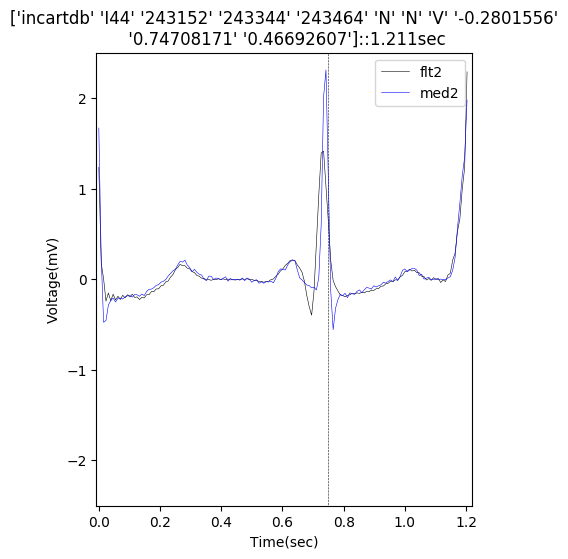

In [47]:

from_beats_array = beats_taken   # beats_info  beats_taken in_data
fbalen = len(from_beats_array)
rdii = random.randint( 0, fbalen-1 ) 
print(str(rdii)+ ' of '+ str(fbalen))
# generate random beat for viwing
rand_beatinfo = from_beats_array[ rdii ]
print(rand_beatinfo)
view_beat((rand_beatinfo),0,100, all_db,g_FLT2_POSTFIX,'black') # g_FLT2_POSTFIX g_MED2_POSTFIX g_RAW2_POSTFIX g_DEN2_POSTFIX
view_beat((rand_beatinfo),0,100, all_db,g_MED2_POSTFIX,'blue')
#def view_beat(binf, ffigure, dotpi, db_dict, g_postfix):

# [3] DATASETS EXTRACTION CRITERIA

In [0]:
def get_bi_label(binfo):
    # a beat is normal only when its adjoing beats are Normal as well 
    if g_map[binfo[6]] == 0:
        if g_map[binfo[5]] == 0 and g_map[binfo[7]] == 0:
            return 0 #'N'
        else:
            return 1 #'B'
    else:
        return 2 #'A'
        

#---------------------------------------------------------------------------------------------------------------
#pad_location = 'left', 'right' , 'both'
def extract_dataset(dataset_file, timesteps, pad_location, pad_value, signal_postfix):
    global g_map
    in_data = np.load(dataset_file)
    data_count = len(in_data)
    label_data = []
    signal_data= np.zeros((0,timesteps))
    print('working...')

    for i in range(0,data_count):
        ib = in_data[i]

        if g_map[ib[6]] < 0:
            print('WARNING: Found unmapped beat - should not be use in evaluation...'+ str(ib))
            #continue
        #=====================================================================================
        sigval, peak, len_time = get_signal( ib, all_db, True, 3, True, signal_postfix )
        siglen = len(sigval)
        #if len_time<max_rri or len_time>min_rri:
            #print('WARNING: Signal window too low '+str(len_time))
        #=====================================================================================
        ned2stack = timesteps-siglen
        if ned2stack ==0 :
            pass # do nothing
        elif ned2stack < 0:
            # Need to crop instead of pad
            need2crop = -ned2stack
            if pad_location == 'left':
                sigval = sigval[need2crop:]
            elif pad_location == 'right':
                sigval = sigval[0:-need2crop]
            elif pad_location == 'both':
                sigval = sigval[ int(need2crop/2) : -(int(need2crop/2)+ need2crop%2)  ]
            else:
                print('ERROR:: Invalid pad')
                return
        else:
            if pad_location == 'left':
                sigval = np.hstack( (np.add( np.zeros( int(ned2stack) ), [pad_value] ), sigval) )
            elif pad_location == 'right':
                sigval = np.hstack( (sigval, np.add( np.zeros( int(ned2stack) ), [pad_value] ) ) )
            elif pad_location == 'both':
                leftstack = np.add(np.zeros(int(ned2stack/2)), [pad_value])
                ritestack = np.add(np.zeros(int(ned2stack/2) + ned2stack%2), [pad_value])
                sigval = np.hstack( ( leftstack, sigval, ritestack ) )
            else:
                print('ERROR:: Invalid pad')
                return
        #=====================================================================================
        #print(len(sigval))
        label_data.append(get_bi_label(ib))
        signal_data = np.vstack( ( signal_data, sigval  ) )
    #---------------------------------------------------------------------------------------------------------------
    print('...done')
    print((signal_data.shape))
    data_len = len(signal_data)
    if data_count != data_len:
        print('WARNING: EXTRACTED DATA COUNT MISMATCH '+str(data_count)+ ' | '+ str(data_len))
    return signal_data, np.array(label_data), in_data, data_len
#---------------------------------------------------------------------------------------------------------------

# [4*] DATASET EXTRACTION

4.0. ** DEFINE SIGNAL PARAMETERS  **

>signal_postfix : which signal type to use (refer g_XXX_POSTFIX)

>timesteps : fixel length of signal  (the extracted signal will be croped or padded to fit this length)

>pad_location : location of pad or crop window ( 'left' 'right' 'both' )

>pad_value : values to be used in padding



NOTE :: These params shall be used further to handel signals in predictive models

In [0]:
#---------------------------------------------------------------------------------------------------------------
signal_postfix = g_MED2_POSTFIX # g_FLT2_POSTFIX
timesteps = int(BASIC_SAMPLING_RATE * 2 ) # seconds  ( padding/cropping )
pad_location = 'right'
pad_value = 1
#---------------------------------------------------------------------------------------------------------------

4.1. List available datasets

In [50]:
dbfiles = os.listdir(global_datadir)
#print(dbfiles)
for i in dbfiles:
    print(i)

svdb_892.npy
svdb_892[data].npy
svdb_892[label].npy
mitdb_213.npy
mitdb_213[data].npy
mitdb_213[label].npy
incart_nv.npy
incart_nv[data].npy
incart_nv[label].npy
incart_nvtest.npy


4.1. EXTRACT SIGNAL USING DEFINED PARAMS


In [51]:
sel_set = 'incart_nvtest' 
sel_file = os.path.join(global_datadir,sel_set+ '.npy')
# Extract signal below
all_sig_data, all_label_data, all_in_data, all_len = extract_dataset(sel_file, timesteps, pad_location, pad_value, signal_postfix )
print('Beats Extracted = '+ str(all_len))
#def extract_dataset(dataset_file, timesteps, pad_location, pad_value, signal_postfix):
#---------------------------------------------------------------------------------------------------------------

working...
...done
(2492, 256)
Beats Extracted = 2492


4.2. Save the extracted data

In [52]:
save_filed = os.path.join(global_datadir,sel_set+ '[data].npy')
np.save(save_filed,all_sig_data)
save_filel = os.path.join(global_datadir,sel_set+ '[label].npy')
np.save(save_filel,all_label_data)
print('saved at '+ str(sel_set))

saved at incart_nvtest


4.3. View a random sample

#2356	['incartdb' 'I44' '436218' '436411' '436539' 'N' 'N' 'V' '-0.2529182'
 '0.75097276' '0.49805447']


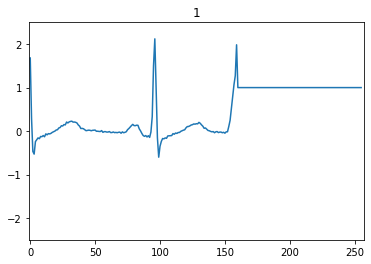

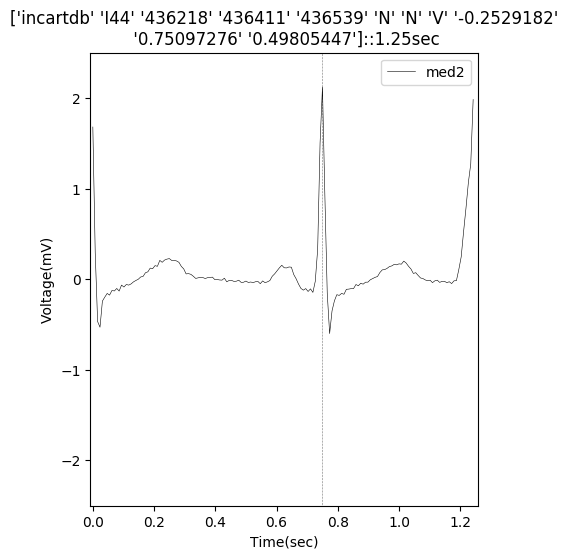

In [53]:
i= random.randint(0, all_len-1 )
print('#'+str(i)+'\t'+ str(all_in_data[i]))
plt.figure(0)
plt.plot(all_sig_data[i])
plt.ylim(-2.5,2.5)
plt.xlim(0-1,timesteps+1)
plt.title(str(all_label_data[i]))
view_beat(all_in_data[i] ,1,100,all_db,signal_postfix,'black')

# [5] MODEL DEFINITIONS

In [0]:
# :: Prepare Network models - FNN and RNN

# call back
cb_esr = tf.keras.callbacks.EarlyStopping(
        monitor='acc', 
        min_delta=0.000001, 
        patience=2, 
        verbose=0, 
        mode='auto', 
        baseline=None, 
        restore_best_weights=False)
cb_listr=[cb_esr] 

# 3.2 :: define network models
cost = 'sparse_categorical_crossentropy'
opt = 'rmsprop'
def getRNN(trainable_lstm, input_shape_temp,input_shape_morph):
    # Build and compile RNN model
    itempo=Input( shape=input_shape_temp, name = "IN_TEMPO")
    denset=Dense(10, activation=tf.nn.relu, name = "DENSE_T")(itempo)

    imorph=Input( shape=input_shape_morph, name = "IN_MORPH")
    lstm1=LSTM(50,batch_input_shape=(timesteps,1),return_sequences=True, name = "LSTM_50")(imorph)
    lstm2=LSTM(150,return_sequences=False, name = "LSTM_150")(lstm1)
    densem=Dense(20, activation=tf.nn.leaky_relu, name = "DENSE_M")(lstm2)

    dconcat = tf.concat([denset,densem],axis=1, name = "CONCAT")
    densef=Dense(10, activation=tf.nn.relu, name = "DENSE_F")(dconcat)
    OPFC=Dense(3, activation=tf.nn.softmax, name = "OUTPUT_FC")(densef)

    model=Model(inputs=[itempo,imorph], outputs=OPFC)
    #-------------------------------------
    model.get_layer(name="LSTM_50").trainable=trainable_lstm
    model.get_layer(name="LSTM_150").trainable=trainable_lstm
    model.compile(loss=cost, optimizer=opt, metrics=['accuracy'])
    #print(model.summary())
    return model

def getRNN_morph(trainable_lstm, input_shape_morph):
    # Build and compile RNN model
    #itempo=Input( shape=input_shape_temp, name = "IN_TEMPO")
    #denset=Dense(10, activation=tf.nn.relu, name = "DENSE_T")(itempo)

    imorph=Input( shape=input_shape_morph, name = "IN_MORPH")
    lstm1=LSTM(50,batch_input_shape=(timesteps,1),return_sequences=True, name = "LSTM_50")(imorph)
    lstm2=LSTM(150,return_sequences=False, name = "LSTM_150")(lstm1)
    densem=Dense(20, activation=tf.nn.leaky_relu, name = "DENSE_M")(lstm2)

    #dconcat = tf.concat([denset,densem],axis=1, name = "CONCAT")
    densef=Dense(10, activation=tf.nn.relu, name = "DENSE_F")(densem)
    OPFC=Dense(3, activation=tf.nn.softmax, name = "OUTPUT_FC")(densef)

    model=Model(inputs=imorph, outputs=OPFC)
    #-------------------------------------
    model.get_layer(name="LSTM_50").trainable=trainable_lstm
    model.get_layer(name="LSTM_150").trainable=trainable_lstm
    model.compile(loss=cost, optimizer=opt, metrics=['accuracy'])
    #print(model.summary())
    return model


# [6] DATASET LOADING

6.1. List available datasets

In [54]:

dbfiles = os.listdir(global_datadir)
#print(dbfiles)
for i in dbfiles:
    print(i)

svdb_892.npy
svdb_892[data].npy
svdb_892[label].npy
mitdb_213.npy
mitdb_213[data].npy
mitdb_213[label].npy
incart_nv.npy
incart_nv[data].npy
incart_nv[label].npy
incart_nvtest.npy
incart_nvtest[data].npy
incart_nvtest[label].npy


6.2 Select a dataset (prefix) and load files

In [55]:
sel_ds = 'incart_nvtest'

#---------------------------------------------------------------
sel_in_file = os.path.join(global_datadir,sel_ds+ '.npy')
sel_data_file = os.path.join(global_datadir,sel_ds+ '[data].npy')
sel_label_file = os.path.join(global_datadir,sel_ds+ '[label].npy')

sel_info = np.load(sel_in_file)
sel_signal = np.load(sel_data_file)
sel_label = np.load(sel_label_file)

sel_len = len(sel_info)
if sel_len != len(sel_signal):
    print('WARNING: DATA COUNT MISMATCH b/w INFO AND SIGNAL DATA')
else:
    if sel_len != len(sel_label):
        print('WARNING: DATA COUNT MISMATCH b/w INFO AND LABEL DATA')
    else:
        print('DATA COUNT WAS CONSISTENT')
print(sel_ds+' : Beats Loaded = ' + str(sel_len))



DATA COUNT WAS CONSISTENT
incart_nvtest : Beats Loaded = 2492


6.3. extract beat information from loaded dataset

>sel_info = np.load(sel_in_file)

>sel_signal = np.load(sel_data_file)

>sel_label = np.load(sel_label_file)

>sel_len = len(sel_info)

In [0]:
#---------------------------------------------------------------
bi_db, bi_rec, bi_pp, bi_pc, bi_pn, bi_lp, bi_lc, bi_ln, bi_srri, bi_prri, bi_nrri = get_binfo_data(sel_info)
#bi_srri = np.absolute(bi_srri)

6.4. view a random sample

#244	['incartdb' 'I02' '54789' '54894' '55129' 'N' 'V' 'N' '0.50583657'
 '0.40856031' '0.91439688']


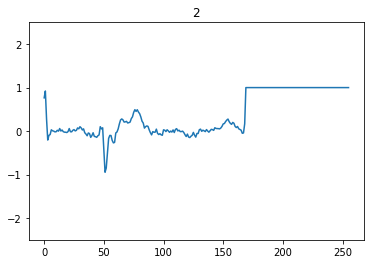

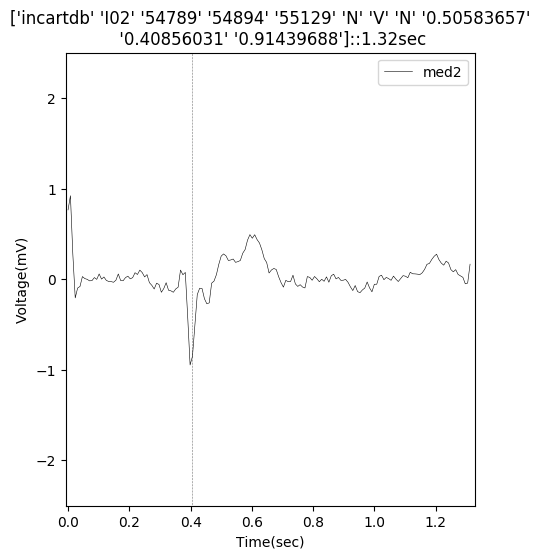

In [24]:
i = random.randint(0, sel_len-1 )
print('#'+str(i)+'\t'+ str(sel_info[i]))
plt.figure(0)
plt.plot(sel_signal[i])
plt.ylim(-2.5,2.5)
#plt.xlim(0-1,sel_len+1)
plt.title(str(sel_label[i]))
view_beat(sel_info[i] ,1,100,all_db,signal_postfix,'black') # g_MED2_POSTFIX signal_postfix
#view_beat(sel_info[i] ,1,100,all_db,g_RAW2_POSTFIX,'red') # g_MED2_POSTFIX signal_postfix

6.5. Shape / Arrange data from Model

In [0]:

# for RNN Models (temporal, morphological and labels)
ds_xm = sel_signal.reshape(sel_len,timesteps,1)
ds_xt = np.transpose(np.vstack((bi_prri,bi_nrri)))
#ds_y = to_categorical(sel_label)#sel_label
ds_y = sel_label



# [7] INITIAL LEARNING

7.0 Check the working dataset

In [26]:
print ('Selected Dataset: '+ sel_ds)

Selected Dataset: incart_nv


7.1. Load Model params

In [27]:
# 1. select global model name to save after training
global_model_name = 'grnn'
if global_model_name == '':
    global_model_name = datetime.datetime.now().strftime('%a_%d_%b_%Y_%H%M%S%f')
global_model_name =  global_model_name + '.h5'
global_model_path = os.path.join(global_modeldir,global_model_name)

# 2. Initialize Global model
model = getRNN(True,(2),(timesteps,1) )
#model = getRNN_morph(True,(2),(timesteps,1) )

# 3. prepare data according to model inputs
data_x = [ds_xt, ds_xm] #ds_xm
data_y = ds_y

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


7.2. Perform Initial Learning and save model

In [28]:
print('Start Training Global Model  '+ global_model_name)
print( datetime.datetime.now() )
print ('use dataset '+ sel_ds)
# Work the model.............................................

model = getRNN(True,(2),(timesteps,1) )
#model = getRNN_morph(True,(2),(timesteps,1) )

print(model.summary())
history = model.fit(
                    data_x, data_y,
                    #batch_size=1000,
                    epochs=300,
                    callbacks=cb_listr,
                    #validation_data=([alle_m.reshape((elen,timesteps,1)),alle_t],alle_l),
                    shuffle=True,
                    verbose=1)



model.save_weights(global_model_path)   #save this model - GRNN0
print('\nSaved Global model @ '+str(global_model_path))

print('End Training Global Model  '+ global_model_name)
print( datetime.datetime.now() )

Start Training Global Model  grnn.h5
2020-03-12 18:01:00.982946
use dataset incart_nv
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
IN_MORPH (InputLayer)           [(None, 256, 1)]     0                                            
__________________________________________________________________________________________________
LSTM_50 (LSTM)                  (None, 256, 50)      10400       IN_MORPH[0][0]                   
__________________________________________________________________________________________________
IN_TEMPO (InputLayer)           [(None, 2)]          0                                            
__________________________________________________________________________________________________
LSTM_150 (LSTM)                 (None, 150)          120600      LSTM_50[0][0]                    
______

# [8] TRANSFER LEARNING


8.0. List available models on disk to choose SOURCE model for tranfer learning

In [0]:
print ('Selected Dataset: '+ sel_ds)
dbfiles = os.listdir(global_modeldir)
for i in dbfiles:
    print(i)

Selected Dataset: mitdb_852
grnn.h5
lrnn.h5


8.1.  Select SOURCE and TARGET models for transfer learning

In [0]:
# 1. Select Source Model to learn from
global_model_name = 'grnn'
global_model_path = os.path.join(global_modeldir,global_model_name+'.h5')

# 2. Select Target model name to save to
local_model_name = 'lrnn'
if local_model_name == '':
    local_model_name = datetime.datetime.now().strftime('%a_%d_%b_%Y_%H%M%S%f')
local_model_name =  local_model_name + '.h5'
local_model_path = os.path.join(global_modeldir,local_model_name)

# 3. Load Target Model
model_target = getRNN(False,(2),(timesteps,1) )
#model_target = getRNN_morph(False,(timesteps,1) )

# 4. prepare data according to model inputs
data_x = [ds_xt, ds_xm] #ds_xm
data_y = ds_y


8.2.  Perform Tranfer learning from source to target model and save the target model

In [0]:
print('Transfer Learning :: '+ global_model_name + ' --> '+ local_model_name )
print( datetime.datetime.now() )
print ('use dataset '+ sel_ds)
# Work the model.............................................

ds_xm = sel_signal.reshape(sel_len,timesteps,1)
ds_xt = np.transpose(np.vstack((bi_prri,bi_nrri)))
#ds_y = to_categorical(sel_label)#sel_label
ds_y = sel_label


model_target.load_weights(global_model_path) 
print(model_target.summary())
history = model_target.fit(
                    [ds_xt,ds_xm], ds_y, 
                    #ds_xm, ds_y, 
                    #batch_size=1000,
                    epochs=300,
                    callbacks=cb_listr,
                    #validation_data=([alle_m.reshape((elen,timesteps,1)),alle_t],alle_l),
                    shuffle=True,
                    verbose=1)

#........................................................................................
model_target.save_weights(local_model_path) 
print('\nSaved Local model @ '+str(local_model_path))
print('Transfer Learning End' )
print( datetime.datetime.now() )

Transfer Learning :: grnn --> lrnn.h5
2020-03-12 11:18:56.245849
use dataset mitdb_852_local
Model: "model_19"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
IN_MORPH (InputLayer)           [(None, 256, 1)]     0                                            
__________________________________________________________________________________________________
LSTM_50 (LSTM)                  (None, 256, 50)      10400       IN_MORPH[0][0]                   
__________________________________________________________________________________________________
IN_TEMPO (InputLayer)           [(None, 2)]          0                                            
__________________________________________________________________________________________________
LSTM_150 (LSTM)                 (None, 150)          120600      LSTM_50[0][0]                   

# [9] PREDICTION

9.0. Prepare Data

In [0]:
# 1. prepare data according to model inputs
data_x = [ds_xt, ds_xm] #ds_xm
data_y = ds_y

9.1. List avaiable models

In [59]:
print ('current dataset '+ sel_ds+'\n')
dbfiles = os.listdir(global_modeldir)
#print(dbfiles)
for i in dbfiles:
    print(i)

current dataset incart_nvtest

grnn.h5


9.2. Choose GLOBAL AND LOCAL MODELS

In [60]:
# 1. global model
global_model_name = 'grnn'
global_model_path = os.path.join(global_modeldir,global_model_name+'.h5')
model_global = getRNN(False,(2),(timesteps,1))#model_global = getRNN_morph(False,(timesteps,1))
model_global.load_weights(global_model_path)
print('\nGLOBAL MODEL: '+global_model_name)
print(model_global.summary())




GLOBAL MODEL: grnn
Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
IN_MORPH (InputLayer)           [(None, 256, 1)]     0                                            
__________________________________________________________________________________________________
LSTM_50 (LSTM)                  (None, 256, 50)      10400       IN_MORPH[0][0]                   
__________________________________________________________________________________________________
IN_TEMPO (InputLayer)           [(None, 2)]          0                                            
__________________________________________________________________________________________________
LSTM_150 (LSTM)                 (None, 150)          120600      LSTM_50[0][0]                    
________________________________________________________________________

Predict using Loaded Model and DataSet

In [61]:
#......................................................................
print ('Predict on dataset '+ sel_ds + ' using model ' + global_model_name)
rnn_pred_global = model_global.predict( data_x ) # array of  samples x classes(4) - each row is a prediction of sample
cmx_global = np.zeros((g_COUNT,g_COUNT),dtype='int32')
cmx2_global = rnn_pred_global.argmax(axis=1)
for i in range(0,len(cmx2_global)):
    alabel = int(ds_y[i])
    plabel = cmx2_global[i]
    cmx_global[alabel,plabel]+=1
print('\tConfusion Matrix')
print(print_conf_matrix( cmx_global,'', g_LABELS)) #logit('\t'+str(cmx))
print_performance( get_performance(cmx_global) ,g_LABELS ) 


Predict on dataset incart_nvtest using model grnn
	Confusion Matrix
A\P	N	B	A
N	306	0	130
B	1362	0	3
A	1	0	690

Performance for 3 classes
Class	ACC	PRE	SEN	SPF
N	0.4	0.18	0.7	0.34
B	0.45	nan	0.0	1.0
A	0.95	0.84	1.0	0.93


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:333: RuntimeWarning: invalid value encountered in true_divide


In [0]:

# 2. local model
local_model_name = 'lrnn'
local_model_path = os.path.join(global_modeldir,local_model_name+'.h5')
model_local = getRNN(False,(2),(timesteps,1))#model_local = getRNN_morph(False,(timesteps,1))
model_local.load_weights(local_model_path)
print('\nLOCAL MODEL: '+local_model_name)
print(model_local.summary())


In [0]:

print('')
#......................................................................
print ('Predict on dataset '+ sel_ds + ' using model ' + local_model_name)
rnn_pred_local = model_local.predict( data_x ) # array of  samples x classes(4) - each row is a prediction of sample
cmx_local = np.zeros((g_COUNT,g_COUNT),dtype='int32')
cmx2_local = rnn_pred_local.argmax(axis=1)
for i in range(0,len(cmx2_local)):
    alabel = int(ds_y[i])
    plabel = cmx2_local[i]
    cmx_local[alabel,plabel]+=1
print('\tConfusion Matrix')
print(print_conf_matrix(cmx_local,'',g_LABELS)) #logit('\t'+str(cmx))
print_performance( get_performance(cmx_local),g_LABELS ) 

# [10] COMPARE PREDICTIONS

Works only when the whole record was used in prediction ( continuation of above cell )

In [62]:
print ('current dataset '+ sel_ds+'\n')

current dataset incart_nvtest



mitdb_213 Duration = 180 sec  [0:180]


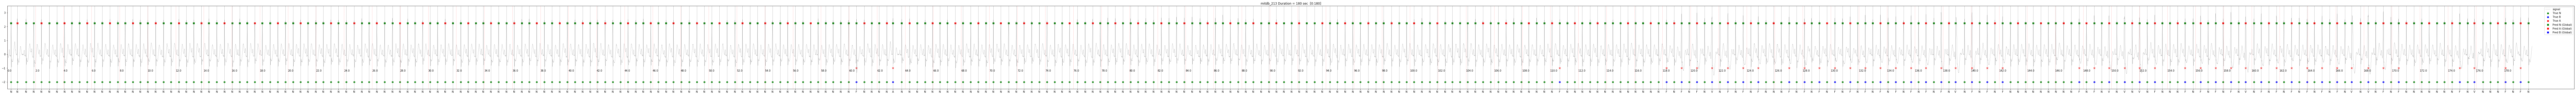

In [67]:
plot_predictions = True# False True
plot_pred_global = True
plot_pred_local = False

# Select a record that was predited ( prediction results in d_train )
test_rec=all_db['mitdb'].get_record('213')

# calculate limits
fs = 0
ts = 180
ds= ts-fs
ff=fs*test_rec.db.srate
tt=ts*test_rec.db.srate
ptitle = test_rec.name+' Duration = '+ str(ds) + ' sec  ['+str(fs)+':'+str(ts) + ']'
print(ptitle)

# plot actual ecg signal
sigX = np.multiply(test_rec.read_data(signal_postfix)[ff:tt],[1/test_rec.gain])
plt.figure(0, figsize=((ds*(60/60)),6))
plt.xlim(0, len(sigX)+3*test_rec.db.srate)
plt.ylim(-2.5,3.5)
plt.plot(sigX, linewidth=0.2, color='black', label='signal')

# plot orignal Annotations
a0 = test_rec.read_data(g_BEAT_POSTFIX)
a0_pk = a0[:,0].astype('int')
a1_pk = a0[:,1]
a1 = a0[(a0_pk>=ff) & (a0_pk<tt)]
a1x = np.subtract(a1[:,0].astype('int'),[ff])
a1y = a1[:,1]
#a1z = np.multiply(a1[:,0].astype('int') , [1/test_rec.db.srate])

a1xx = a1x[a1y!='N']
plt.scatter(a1xx,np.subtract(np.zeros(len(a1xx)),[1]), color='red',marker='x') #plt.scatter(a1x,a1y)

atsecX = np.arange(0,len(sigX),2*test_rec.db.srate) #<---------------------------------multiply for each second
#atsecY = np.multiply(np.arange(ff,tt,test_rec.db.srate),[1/test_rec.db.srate] )
for i in range(0,len(atsecX)):
    plt.annotate( str(round((atsecX[i]+ff)/test_rec.db.srate,2)), xy=(atsecX[i],-1.25))
    plt.vlines(atsecX[i], -2.5,3.5, linewidth=0.5, linestyles='dotted', color='red' )

#plt.xticks(np.arange(0,len(sigX),test_rec.db.srate), np.multiply(np.arange(ff,tt,test_rec.db.srate),[1/test_rec.db.srate] ))
plt.xticks(a1x,a1y)

plt.grid(axis='x')
# # bi_db, bi_rec, bi_pp, bi_pc, bi_pn, bi_lp, bi_lc, bi_ln, bi_srri, bi_prri, bi_nrri = get_binfo_data(sel_info)
if plot_predictions:
    # use params from previous cell * Use alld_m to plot actual downsampled ecg signals used by Model in training
    allpeak = a0_pk #a0[:,0].astype('int') np.subtract(a1[:,0].astype('int'),[ff])
    sidx = np.arange(0,len(allpeak),1)
    speak = allpeak[sidx[(allpeak>=ff) & (allpeak<tt)]]
    slab = a1_pk[sidx[(allpeak>=ff) & (allpeak<tt)]]
    #ssig = alld_m[sidx[(allpeak>=ff) & (allpeak<tt)]]
    sfpeaks = np.subtract(speak,[ff])

    # Scatter plot Ground Truth Labels
    slabint = mapstd(slab) #[sidx[(allpeak>=ff) & (allpeak<tt)]].astype('int') #slab.astype('int') #g_LABELS[slab.astype('int')]  plt.xticks(sfpeaks,slabint)
    zi = sfpeaks[slabint==0]
    plt.scatter(zi,np.subtract(np.zeros(len(zi)),[2]),color = 'green', marker='o', label = 'True N')
    zi = sfpeaks[slabint==1]
    plt.scatter(zi,np.subtract(np.zeros(len(zi)),[2]),color = 'blue', marker='o', label = 'True B')
    zi = sfpeaks[slabint==2]
    plt.scatter(zi,np.subtract(np.zeros(len(zi)),[2]),color = 'red', marker='o', label = 'True A')

    # Scatter plot Predicted Labels
    # _global _local
    if plot_pred_global:
        scmx_global = cmx2_global[sidx[(allpeak>=ff) & (allpeak<tt)]]
        spred_global =rnn_pred_global[sidx[(allpeak>=ff) & (allpeak<tt)]]
        zi = sfpeaks[scmx_global==0]
        plt.scatter(zi,np.add(np.zeros(len(zi)),[2.25]),color = 'green', marker='s', label = 'Pred N (Global)')
        zi = sfpeaks[scmx_global==2]
        plt.scatter(zi,np.add(np.zeros(len(zi)),[2.25]),color = 'red', marker='s', label = 'Pred A (Global)')
        zi = sfpeaks[scmx_global==1]
        plt.scatter(zi,np.add(np.zeros(len(zi)),[2.25]),color = 'blue', marker='s', label = 'Pred B (Global)')

    if plot_pred_local:
        scmx_local = cmx2_local[sidx[(allpeak>=ff) & (allpeak<tt)]]
        spred_local =rnn_pred_local[sidx[(allpeak>=ff) & (allpeak<tt)]]
        zi = sfpeaks[scmx_local==0]
        plt.scatter(zi,np.add(np.zeros(len(zi)),[2]),color = 'green', marker='d', label = 'Pred N (Local)')
        zi = sfpeaks[scmx_local==2]
        plt.scatter(zi,np.add(np.zeros(len(zi)),[2]),color = 'red', marker='d', label = 'Pred A (Local)')
        zi = sfpeaks[scmx_local==1]
        plt.scatter(zi,np.add(np.zeros(len(zi)),[2]),color = 'blue', marker='d', label = 'Pred B (Local)')
        

    # plot prediction probability
    #plt.scatter(sfpeaks,spred[:,0], color='green')
    #plt.scatter(sfpeaks,spred[:,1], color='red')
    #plt.annotate('Global',xy=(-100,2),color='blue')
    #plt.annotate('Local',xy=(-100,1.75),color='black')
    #for i in range (0, len(scmx_global)):
    #    if scmx_global[i]!=scmx_local[i]:
    #        plt.annotate('X', xy=(sfpeaks[i],1.5))

     #       g_conf = round( spred_global[i][scmx_global[i]] , 2)
     #       l_conf = round( spred_local[i][scmx_local[i]] , 2)
     #       plt.annotate(str(g_conf), xy=(sfpeaks[i],3), color='navy')
     #       plt.annotate(str(l_conf), xy=(sfpeaks[i],2.75),color='black')

else:
    print('No predictions were plotted')
plt.title(ptitle)
plt.legend()

# --- ARCHIVE ---